In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [36]:
#필요 라이브러리 임포트
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['axes.unicode_minus'] = False
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

# interactive graph
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

In [37]:
titanic_train = pd.read_csv('/kaggle/input/titanic/train.csv')
titanic_test = pd.read_csv('/kaggle/input/titanic/test.csv')

### EDA

In [38]:
print(titanic_train.shape)
titanic_train.head(3)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [39]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- 12개의 column을 가지고 있고 전체 891개의 데이터

In [40]:
fig = px.bar(titanic_train,title = 'feature 별 null 값 갯수', x=titanic_train.isnull().sum().sort_values(ascending = False).index, y=titanic_train.isnull().sum().sort_values(ascending = False), text = titanic_train.isnull().sum().sort_values(ascending = False),height= 500)
fig.show()

-  **null 값의 개수** : Cabin은 약 700개, Age는 180개의 null값을 가지고 있다.

In [41]:
fig = px.bar(titanic_train,title = '생존자 비율 확인', x=[0,1], y=titanic_train['Survived'].value_counts() / len(titanic_train), text = (titanic_train['Survived'].value_counts() / len(titanic_train)).round(2), color=titanic_train['Survived'].value_counts(),color_continuous_scale=['green','red'],width=600, height= 500)
fig.show()

In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

data = titanic_train.groupby(['Sex','Survived'])['Survived'].count()
labels = ["Survived = 0", "Survived = 1"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=[data[2], data[3]], name="male", marker_colors = ["red","green"]),1, 1)
fig.add_trace(go.Pie(labels=labels, values=[data[0], data[1]], name="female"),1, 2)

fig.update_traces(hole=.4)

fig.update_layout(
    title_text="성별에 따른 생존자 비율",
    annotations=[dict(text='Male', x=0.19, y=0.5, font_size=20, showarrow=False),
                 dict(text='Female', x=0.83, y=0.5, font_size=20, showarrow=False)])
fig.show()

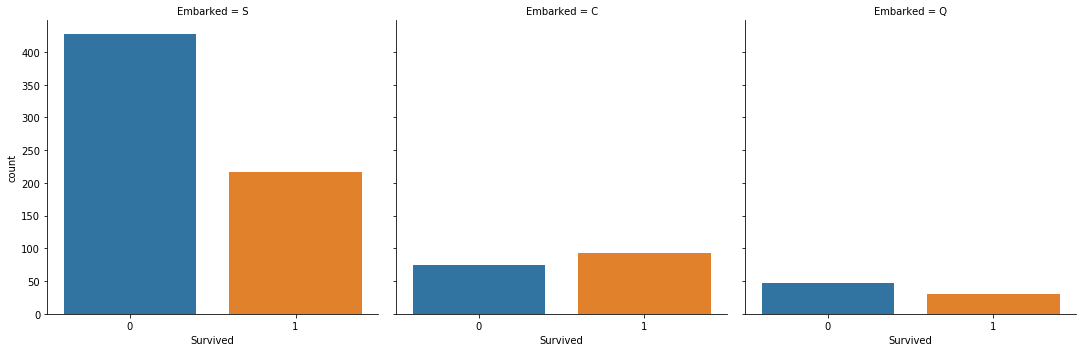

In [43]:
# class 별 생존자 확인
sns.catplot(x='Survived', col='Embarked', kind='count', data=titanic_train)

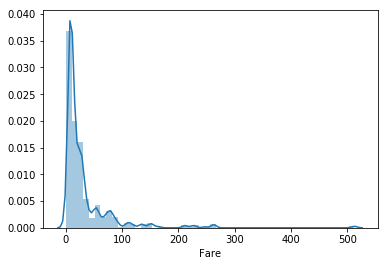

In [44]:
sns.distplot(titanic_train['Fare'])

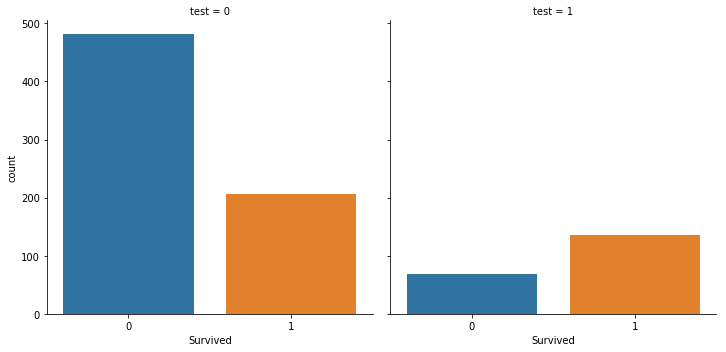

In [45]:
# Cabin 값 유무에 따른 생존자 수 확인
titanic_train['test'] = titanic_train['Cabin'].fillna('N').apply(lambda x : 0 if x[0] == 'N' else 1)

sns.catplot(x='Survived', col='test', kind='count', data=titanic_train)

**Cabin** 값의 유무에 따라 생존율이 달라지는 것을 볼 수 있다.

### Data Processing

In [46]:
def fare(data):
    if data['Age'] == 0:
        if data.Embarked == 'C':
            if data.Pclass == 1:
                return 36.5
            elif data.Pclass == 2:
                return 25
            else:
                return 20
        elif data.Embarked == 'S':
            if data.Pclass == 1:
                return 37
            elif data.Pclass == 2:
                return 30
            else:
                return 25
        else:
            # Q에 대한 인원이 많지 않아 하나로 통합
            return 27
    else:
        return data['Age']
    
def func_age(data):
    if data < 3: return 0
    elif data < 8: return 1
    elif data < 14: return 2
    elif data < 20: return 3
    elif data < 30: return 4
    elif data < 40: return 5
    elif data < 60: return 6
    else: return 7

def data_processing(df):
    # Age null 값 채우기 / Embarked & Pclass 별 Age 중앙값
    df['Age'].fillna(0, inplace=True)
    df['new_Age'] = df[['Embarked', 'Pclass', 'Age']].apply(fare, axis = 1)
    df.drop(['Age'], axis = 1, inplace = True)
    df['Age'] = df['new_Age'].apply(func_age)
    
    # Cabin 값이 있는 경우 / 없는 경우
    df['Cabin'].fillna('N',inplace=True)
    df['Cabin'] =  df['Cabin'].apply(lambda x : 0 if x[0] == 'N' else 1)
    
    
    df['Embarked'].fillna('C',inplace=True)
    df['Fare'].fillna(df['Fare'].median(),inplace=True)
    
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
        
    # df['Cabin'] = df['Cabin'].str[:1]
    features = ['Sex']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    # pd.get_dummies로 One-hot 인코딩
    college_one_hot_encoded = pd.get_dummies(df['Embarked']) 

    # 원래 데이터와 비교식으로 보여주기용 데이터프레임
    df = pd.concat([df, college_one_hot_encoded], axis=1) 
        
    df['Familiy_size'] = df['SibSp'] + df['Parch']
    df.drop(['SibSp','Parch','Embarked','new_Age'],axis=1,inplace=True)
    
    return df

In [47]:
titanic_df = pd.read_csv('/kaggle/input/titanic/train.csv')

y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived',axis=1)

X_titanic_df = data_processing(X_titanic_df)

X_titanic_df.head(3)

,Pclass,Sex,Fare,Cabin,Age,C,Q,S,Familiy_size
0,3,1,7.2500,0,4,0,0,1,1
1,1,0,71.2833,1,5,1,0,0,1
2,3,0,7.9250,0,4,0,0,1,0


### Data Analysis

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

params = { 'max_depth':3,
           'eta': 0.1,
           'objective':'binary:logistic',
           'eval_metric':'logloss',
           'early_stoppings':100
        }
num_rounds = 400


# 0.8328
def data_analysis(data_x, data_y):
    X_train, X_test, y_train, y_test=train_test_split(data_x, data_y,random_state=0)
 
    dt_clf = DecisionTreeClassifier(random_state=0)
    
    lr_clf = LogisticRegression()
    knn_clf = KNeighborsClassifier(n_neighbors=10)
    
    gb_clf = GradientBoostingClassifier(random_state=0, max_depth = 4, learning_rate=0.01, n_estimators = 100)
    
    rf_clf = RandomForestClassifier(random_state=0, max_depth = 4, class_weight = 'balanced', n_estimators = 100)
    
    xgb_clf_1 = XGBClassifier(random_state=0, objective = 'binary:logistic', learning_rate=0.01, max_depth=5, n_estimators = 100)
    xgb_clf_1.fit(X_train , y_train, eval_metric="rmse", verbose=True)
    
    pred = xgb_clf_1.predict(X_test)
    print('{0} 정확도: {1:.4f}'.format(xgb_clf_1.__class__.__name__, accuracy_score(y_test , pred)))
    
    xgb_clf_2 = XGBClassifier(random_state=1, objective = 'binary:logistic', learning_rate=0.01, max_depth=4, n_estimators = 50)
    xgb_clf_2.fit(X_train , y_train, eval_metric="rmse", verbose=True)
    
    pred = xgb_clf_2.predict(X_test)
    print('{0} 정확도: {1:.4f}'.format(xgb_clf_2.__class__.__name__, accuracy_score(y_test , pred)))
    
    xgb_clf_3 = XGBClassifier(random_state=2, objective = 'binary:logistic', learning_rate=0.01, max_depth=4, n_estimators = 100)
    xgb_clf_3.fit(X_train , y_train, eval_metric="rmse", verbose=True)
    
    pred = xgb_clf_3.predict(X_test)
    print('{0} 정확도: {1:.4f}'.format(xgb_clf_3.__class__.__name__, accuracy_score(y_test , pred)))
    
    # voting : 0.87 / rf, xgb
    vo_clf = VotingClassifier(estimators=[ # ('dt',dt_clf),
                                           ('rf',rf_clf),
                                           # ('lr',lr_clf),
                                           # ('knn',knn_clf),
                                           ('gb',gb_clf),
                                           ('xgb1',xgb_clf_1),
                                           ('xgb2',xgb_clf_2),
                                           ('xgb3',xgb_clf_3)
    ]
                              ,voting='soft')
    vo_clf.fit(X_train , y_train)
    pred = vo_clf.predict(X_test)
    print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

    # 개별 모델의 학습/예측/평가.
    classifiers = [dt_clf, rf_clf, lr_clf, knn_clf, gb_clf]
    for classifier in classifiers:
        classifier.fit(X_train , y_train)
        pred = classifier.predict(X_test)
        class_name= classifier.__class__.__name__
        print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))
    
    # result = rf_pred
    print()
    print()
    # exec_kfold 호출
    classifiers = [gb_clf, rf_clf, xgb_clf_1, vo_clf]
    for classifier in classifiers:
        print(classifier.__class__.__name__)
        exec_kfold(data_x, data_y, classifier)
        print()
        print()

In [49]:
def exec_kfold(data_x, data_y, clf, folds=3):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한  리스트 객체 생성.
    kfold = KFold(n_splits=folds, shuffle=True,random_state=2)
    scores = []
    
    # KFold 교차 검증 수행. 
    for iter_count , (train_index, test_index) in enumerate(kfold.split(data_x)):
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = data_x.values[train_index], data_x.values[test_index]
        y_train, y_test = data_y.values[train_index], data_y.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산 
        clf.fit(X_train, y_train) 
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))     
    
    # 5개 fold에서의 평균 정확도 계산. 
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score))

In [50]:
data_analysis(X_titanic_df, y_titanic_df)

XGBClassifier 정확도: 0.8251
XGBClassifier 정확도: 0.8117
XGBClassifier 정확도: 0.8161
Voting 분류기 정확도: 0.8251
DecisionTreeClassifier 정확도: 0.7982
RandomForestClassifier 정확도: 0.8161
LogisticRegression 정확도: 0.8206
KNeighborsClassifier 정확도: 0.7489
GradientBoostingClassifier 정확도: 0.8386


GradientBoostingClassifier
교차 검증 0 정확도: 0.7946
교차 검증 1 정확도: 0.8215
교차 검증 2 정확도: 0.8384
평균 정확도: 0.8182


RandomForestClassifier
교차 검증 0 정확도: 0.8047
교차 검증 1 정확도: 0.8182
교차 검증 2 정확도: 0.7912
평균 정확도: 0.8047


XGBClassifier
교차 검증 0 정확도: 0.8013
교차 검증 1 정확도: 0.8316
교차 검증 2 정확도: 0.7980
평균 정확도: 0.8103


VotingClassifier
교차 검증 0 정확도: 0.7980
교차 검증 1 정확도: 0.8215
교차 검증 2 정확도: 0.8148
평균 정확도: 0.8114




In [51]:
#titanic_df = pd.read_csv('/kaggle/input/titanic/train.csv')
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [ ]:
def data_analysis_final(X_train, y_train, titanic_test):
    # X_train, X_test, y_train, y_test=train_test_split(data_x, data_y,random_state=0)
    gb_clf = GradientBoostingClassifier(random_state=0, max_depth = 4, learning_rate=0.01, n_estimators = 100)
    
    gb_clf1 = GradientBoostingClassifier(random_state=1, max_depth = 5, learning_rate=0.01, n_estimators = 100)
    
    rf_clf = RandomForestClassifier(random_state=0, max_depth = 4, class_weight = 'balanced', n_estimators = 100)
    
    rf_clf1 = RandomForestClassifier(random_state=1, max_depth = 5, class_weight = 'balanced', n_estimators = 100)
    
    xgb_clf_1 = XGBClassifier(random_state=0, objective = 'binary:logistic',eval_metric="rmse", learning_rate=0.01, max_depth=5, n_estimators = 100)
    
    xgb_clf_2 = XGBClassifier(random_state=1, objective = 'binary:logistic',eval_metric="rmse", learning_rate=0.01, max_depth=4, n_estimators = 50)
    
    xgb_clf_3 = XGBClassifier(random_state=2, objective = 'binary:logistic',eval_metric="rmse", learning_rate=0.01, max_depth=4, n_estimators = 100)
    
    # voting : 0.87 / rf, xgb
    vo_clf = VotingClassifier(estimators=[ # ('dt',dt_clf),
                                           ('rf',rf_clf),
                                           ('rf1',rf_clf1),
                                           # ('lr',lr_clf),
                                           # ('knn',knn_clf),
                                           ('gb',gb_clf),
                                           ('gb1',gb_clf1),
                                           ('xgb1',xgb_clf_1),
                                           ('xgb2',xgb_clf_2),
                                           ('xgb3',xgb_clf_3)
    ]
                              ,voting='soft')
    vo_clf.fit(X_train , y_train)
    
    pred = vo_clf.predict(titanic_test)
    
    return pred

In [ ]:
titanic_test = pd.read_csv('/kaggle/input/titanic/test.csv')

pred = data_analysis_final(X_titanic_df, y_titanic_df, data_processing(titanic_test))

In [ ]:
output = pd.DataFrame({
        "PassengerId": submission["PassengerId"],
        "Survived": pred
    })
output.to_csv('submission.csv', index=False)